<a href="https://colab.research.google.com/github/ndow33/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [142]:
df['shot_made_flag'].value_counts(normalize = True)

0    0.527081
1    0.472919
Name: shot_made_flag, dtype: float64

In [0]:
#Baseline accuracy would be about 53% if we guessed the majority class for every
#prediction

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [144]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [145]:
df.shape

(13958, 20)

In [146]:
#convert 'game_date' to datetime
df['game_date'] = pd.to_datetime(df['game_date'])
df['game_date'].head()

0   2009-10-28
1   2009-10-28
2   2009-10-28
3   2009-10-28
4   2009-10-28
Name: game_date, dtype: datetime64[ns]

In [147]:
#make a filter for the 2018 season 
condition = (df['game_date'].dt.year >= 2018) & (df['game_date'].dt.month >= 10)

#make the test df with this filter
test = df[condition]

#double check the shape
test.shape

(526, 20)

In [148]:
#make a filter for the 2019 season
condition = (df['game_date'].dt.year >= 2019)
test2 = df[condition]
test2.shape

(1183, 20)

In [149]:
#combine the data
test = pd.concat([test,test2])
test.shape

(1709, 20)

In [150]:
#get the training df for 2017 and before
condition = df['game_date'].dt.year <= 2017
train = df[condition]
train.shape

(11504, 20)

In [151]:
#get the training df for up to june 2018
condition = (df['game_date'].dt.year == 2018) & (df['game_date'].dt.month <= 7)
train2 = df[condition]
train2.shape


(745, 20)

In [152]:
#combine the data
train = pd.concat([train,train2])
train.shape, test.shape

((12249, 20), (1709, 20))

In [153]:
1709+12249

13958

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [154]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [155]:
#engineer homecourt advantage feature as hm_adv

df['hm_adv'] = 0
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,0


In [156]:
counter = 0
for x in df['htm']:
  if x == 'GSW':
    df.loc[counter,'hm_adv'] = 1
  
  counter = counter + 1

df.head(15)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1
5,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,2009-10-28,GSW,HOU,Regular Season,4.0,1
6,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,2009-10-28,GSW,HOU,Regular Season,-9.0,1
7,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,2009-10-28,GSW,HOU,Regular Season,-6.0,1
8,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,2009-10-28,GSW,HOU,Regular Season,-9.0,1
9,20900015,490,Stephen Curry,4,1,47,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,2009-10-28,GSW,HOU,Regular Season,-7.0,1


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [157]:
#Get the training data set
#make a condition to capture all of the games in 2016 and before
condition = df['game_date'].dt.year <= 2016
train = df[condition]
train.shape

(9895, 21)

In [158]:
#get the training df for up to june 2017
condition = (df['game_date'].dt.year == 2017) & (df['game_date'].dt.month <= 7)
train2 = df[condition]
train2.shape

(1186, 21)

In [159]:
#combine the two dataframes
train = pd.concat([train,train2])
train.shape

(11081, 21)

In [160]:
#get the validation set
#make a filter for the 2017 season 
condition = (df['game_date'].dt.year == 2017) & (df['game_date'].dt.month >= 10)

#make the test df with this filter
val = df[condition]

#double check the shape
val.shape

(423, 21)

In [161]:
#get the val df for up to june 2018
condition = (df['game_date'].dt.year == 2018) & (df['game_date'].dt.month <= 7)
val2 = df[condition]
val2.shape

(745, 21)

In [162]:
#concat the two val dataframes
val = pd.concat([val,val2])
val.shape

(1168, 21)

In [163]:
#make a filter for the 2018 season 
condition = (df['game_date'].dt.year >= 2018) & (df['game_date'].dt.month >= 10)

#make the test df with this filter
test = df[condition]

#double check the shape
test.shape

(526, 21)

In [164]:
#make a filter for the 2019 season
condition = (df['game_date'].dt.year >= 2019)
test2 = df[condition]
test2.shape

(1183, 21)

In [165]:
#combine the data
test = pd.concat([test,test2])
test.shape

(1709, 21)

In [0]:
#Set the target
target = 'shot_made_flag'
#get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])
#Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
#get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
#get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
#combine the lists
features = numeric_features + categorical_features

In [0]:
#arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]


## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [168]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.one_hot.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'shot_typ...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                   

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [169]:
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

Validation accuracy: 0.5445205479452054


## 7. Get your model's test accuracy

> (One time, at the end.)

In [170]:
print(f'Validation accuracy: {pipeline.score(X_test, y_test)}')

Validation accuracy: 0.5792861322410766


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [171]:
correct = 85 + 36
total = 85 + 8 + 58 + 36
accuracy = correct/total
accuracy

0.6470588235294118

### Calculate precision

In [172]:
true_pos_neg = 85
neg_pred = 85 + 8

neg_precision = true_pos_neg/neg_pred
neg_precision

0.9139784946236559

In [173]:
true_pos_pos = 36
pos_pred = 36 + 58

pos_precision = true_pos_pos/pos_pred
pos_precision

0.3829787234042553

### Calculate recall

In [174]:
total_neg = 85 + 58
recall_neg = true_pos_neg/total_neg
recall_neg

0.5944055944055944

In [175]:
total_pos = 8 + 36
recall_pos = true_pos_pos/total_pos
recall_pos

0.8181818181818182

#Engineer 4+ new features total, either from the list above, or your own ideas.
Opponent: Who is the other team playing the Golden State Warriors?

Seconds remaining in the period: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.

Seconds remaining in the game: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.

Made previous shot: Was Steph Curry's previous shot successful?

In [176]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1


In [177]:
#engineer opponent feature
df['opponent'] = 'team'
df.head(1)


,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,team


In [178]:

counter = 0
for x in df['htm']:
  if x == 'GSW':
    df.loc[counter,'opponent'] = df.loc[counter, 'vtm']
  else:
    df.loc[counter,'opponent'] = df.loc[counter, 'htm']
  
  counter = counter + 1

df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU


In [179]:
#Seconds remaining in the period feature
df['rem_secs_in_period'] = 0
df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent,rem_secs_in_period
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,0


In [180]:
counter = 0
for x in df['minutes_remaining']:
  secs = df.loc[counter, 'seconds_remaining']
  mins_to_secs = df.loc[counter, 'minutes_remaining']*60
  secs_rem = secs + mins_to_secs
  df.loc[counter, 'rem_secs_in_period'] = secs_rem
  
  counter = counter + 1

df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent,rem_secs_in_period
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,685


In [0]:
#Remaining seconds in game
df['rem_secs_in_game'] = 0


In [182]:
counter = 0
for x in df['rem_secs_in_period']:
  full_periods_left = (4 - df.loc[counter, 'period']) * 12 * 60
  df.loc[counter, 'rem_secs_in_game'] = x + full_periods_left
    
  counter = counter + 1

df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent,rem_secs_in_period,rem_secs_in_game
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,685,2845


In [0]:
#Made previous shot: Was Steph Curry's previous shot successful?
df['made_prev_shot'] = 0

In [0]:
counter = 0 
prev_shot = 0

for x in df['shot_made_flag']:
  if prev_shot == 0:
    df.loc[counter, 'made_prev_shot'] = 0
  else:
    df.loc[counter, 'made_prev_shot'] = 1
  
  counter = counter + 1
  prev_shot = df.loc[(counter-1), 'shot_made_flag']


In [185]:
df.head(15)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent,rem_secs_in_period,rem_secs_in_game,made_prev_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,685,2845,0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0,1,HOU,571,2731,0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,HOU,362,2522,1
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0,1,HOU,589,2029,0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0,1,HOU,139,1579,0
5,20900015,277,Stephen Curry,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,2009-10-28,GSW,HOU,Regular Season,4.0,1,HOU,34,1474,0
6,20900015,413,Stephen Curry,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,2009-10-28,GSW,HOU,Regular Season,-9.0,1,HOU,626,626,0
7,20900015,453,Stephen Curry,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,2009-10-28,GSW,HOU,Regular Season,-6.0,1,HOU,391,391,1
8,20900015,487,Stephen Curry,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,2009-10-28,GSW,HOU,Regular Season,-9.0,1,HOU,145,145,1
9,20900015,490,Stephen Curry,4,1,47,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,2009-10-28,GSW,HOU,Regular Season,-7.0,1,HOU,107,107,1


#Make 2+ visualizations to explore relationships between features and target.

In [186]:
df.head(1)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot,hm_adv,opponent,rem_secs_in_period,rem_secs_in_game,made_prev_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0,1,HOU,685,2845,0


In [187]:
#filter the data
df['shot_zone_range'].describe

<bound method NDFrame.describe of 0                24+ ft.
1              16-24 ft.
2               8-16 ft.
3              16-24 ft.
4              16-24 ft.
              ...       
13953           8-16 ft.
13954           8-16 ft.
13955            24+ ft.
13956    Less Than 8 ft.
13957            24+ ft.
Name: shot_zone_range, Length: 13958, dtype: object>

In [188]:
condition = df['shot_zone_range'] == '16-24 ft.'
midrange = df[condition]
#find his midrange shooting percentage
midmean = midrange['shot_made_flag'].mean()
midmean

0.4627049180327869

In [189]:
condition = df['shot_zone_range'] == '8-16 ft.'
shortrange = df[condition]
#find his shortrange shooting percentage
shortmean = shortrange['shot_made_flag'].mean()
shortmean

0.4433460076045627

In [190]:
condition = df['shot_zone_range'] == 'Less Than 8 ft.'
closerange = df[condition]
#find his shortrange shooting percentage
closemean = closerange['shot_made_flag'].mean()
closemean

0.5764566696243715

In [191]:
condition = df['shot_zone_range'] == '24+ ft.'
longrange = df[condition]
#find his shortrange shooting percentage
longmean = longrange['shot_made_flag'].mean()
longmean

0.4365421812230323

In [0]:
shot_types = ['close-range', 'short-range', 'mid-range', 'long-range']
means = [closemean, shortmean, midmean, longmean]

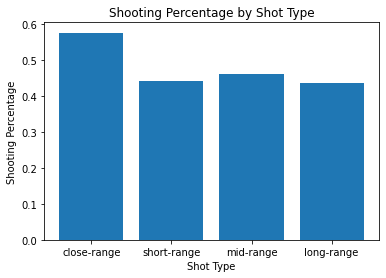

In [193]:
import matplotlib.pyplot as plt

plt.bar(shot_types, means)
plt.title('Shooting Percentage by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Shooting Percentage');
